# Regression Models in Keras

**Objective:** Build a forward-feed regression model in keras

As you recall, a regression problem is one in which you try to predict a continuous value.  One example is predicting the miles-per-gallon that a vehicle may run for. Let’s try this in Keras.

**In this lesson, we will:**
1. Import necessary libraries.
2. Load and process the data.
3. Build a feed-forawrd regression model with an appropriate output layer and loss function.
4. Evaluate the model using regression metrics.

## Libraries, functions

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
 
# Sci-kit learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

## Load and preprocess data

The data we will be using for this model is hosted by the University of Irvine Machine Learning Repository. According to the original paper that presented the data:

"The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)

The data contains both continuous and discrete (categorical) features. Since the categories are numeric, Pandas will import them as integer types, but we will one-hot encode them.

In [4]:
# Import data
reg_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTg36jLawSOgGP9hp0oJ3OYZiHMWbuGLiau-8DMjtcKNv7v9Zy_zFBQs9gZU-44GGeIyfXE2iwo26_z/pub?output=csv'
df_reg = pd.read_csv(reg_url)
 
# Drop car name columns
df_reg = df_reg.drop(columns='car name')
df_reg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [5]:
# Check missing values and duplicates
print('missing values', df_reg.info())
print('\nduplicated rows', df_reg.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 24.6 KB
missing values None

duplicated rows 0


In [6]:
# Split data
X = df_reg.drop(columns='mpg')
y = df_reg['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

**Preprocess**

In [7]:
# lists of columns for transformer
cat_cols = ['cylinders','model year','origin']
num_cols = X_train.columns.drop(cat_cols)

# PREPROCESSING PIPELINE FOR NUMERIC DATA

# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)


# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA

# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, cat_cols)

# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
# Fit on training data
col_transformer.fit(X_train)

# Transform the training data
X_train_tf = col_transformer.transform(X_train)
# Transform the testing data
X_test_tf = col_transformer.transform(X_test)
# View the processed training data
X_train_tf.head()

,displacement,horsepower,weight,acceleration,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,model year_70,...,model year_76,model year_77,model year_78,model year_79,model year_80,model year_81,model year_82,origin_1,origin_2,origin_3
265,-0.588476,-0.245826,-0.490076,-0.458303,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16,0.033663,-0.193925,-0.235417,-0.002504,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66,2.235078,2.686610,1.976787,-1.580270,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
158,0.339946,0.143435,1.112849,1.925875,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,2.340363,2.868265,1.594798,-2.456806,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Build and train model

In [8]:
# First, let's define shape
input_shape = X_train_tf.shape[1]
input_shape

25

We will set the input dimensions to the number of columns in our processed data so Keras can construct an implicit input layer. We will then construct a fairly small model with two hidden layers and 10 nodes in each layer.

Since this is a regression model, the final layer should have one node and a linear activation function.  We will also include a dropout layer.

**Loss**

We need to be sure to use a regression metric for the loss function. A loss function must always decrease as the model error decreases. For this reason, for instance, R2 would not work as a loss function since it increases as the model learns.

Most deep-learning regression models will use MSE as the loss functions.

**Optimizer**

Optimizers are optional but can speed up learning. The ‘Adam’ optimizer is popular for all model types that use gradient descent for learning.

If you want to know more, you can refer to the documentation. https://keras.io/api/optimizers/

**Metrics**

We can, optionally, add a list of metrics to our compile call, and the model will keep track of how those metrics change in each epoch. Some metrics are accessible as string shortcuts, such as ‘mse,’ but others must be instantiated as metrics classes, like:

metrics.MeanAbsoluteError()

This is different from Sci-kit Learn. In Sci-kit Learn, we used functions to return metrics, but Keras expects classes that are instantiated for each model. This is because, behind the scenes, these class instances will be fit on the specific data so they can make calculations more quickly. Tensorflow is all about efficiency! The history of these metrics for each epoch will be stored in a dictionary returned by the .fit() method.

A list of available metrics can be found at: https://keras.io/api/metrics/

We will build our model within a function.​

In [10]:
# Build regression model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(10, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(10, 
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'linear'))
    
    # Compile Model
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model

In [11]:
## Now, call our function and check out our model sumamry.
# Call our build function to build model
reg_model = build_model()

# Get model summary
reg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                260       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


Now, define an early stopping callback.

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

Next, we fit the model and save the learning history. We will set the verbosity to 0 to avoid the long, epoch by epoch output, but you can change that if you like to see the numbers go by during training.

In [14]:
history = reg_model.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=100,
                        verbose=0, callbacks = [early_stop])

We can plot the learning history for the loss function and the metrics we asked the model to keep track of in the .compile() call. These are all stored in the history dictionary.

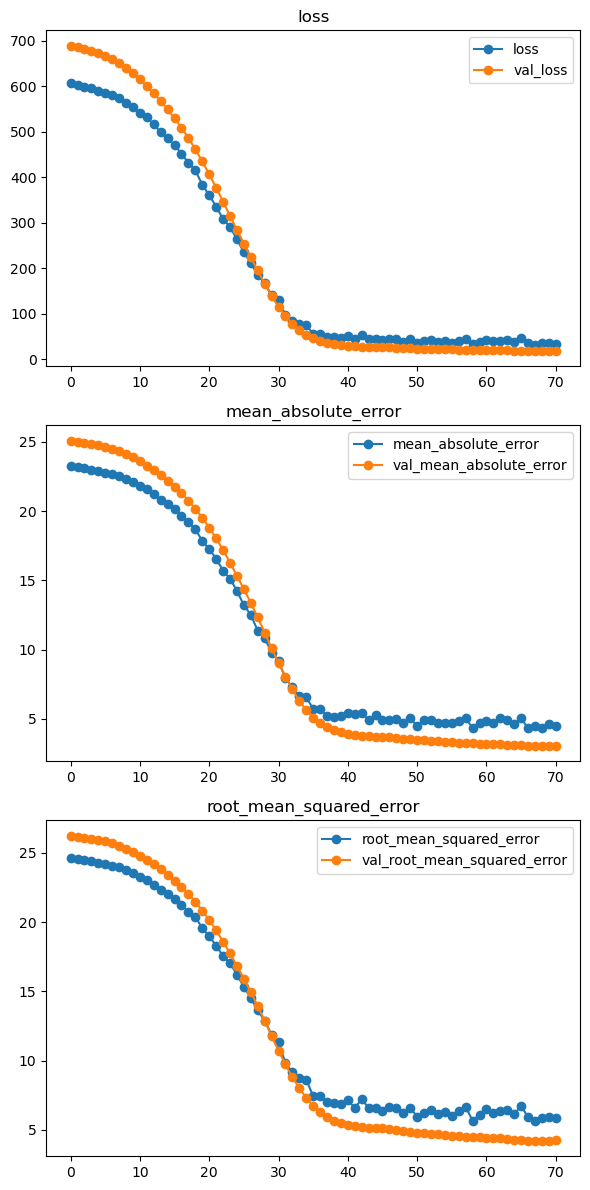

In [15]:
# plot learning 
plot_history(history);

This model has a nice hockey-stick-shaped learning curve, and the final training and testing scores are similar. It does not seem to suffer greatly from overfitting or underfitting. However, let’s check the metrics using Sci-kit learn metrics functions to get some solid numbers.

Evaluating a final regression model in Keras is similar to evaluating a more traditional Sci-kit Learn model.

In [16]:
# Evaluate model
y_pred = reg_model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

4/4 [==============================] - 0s 2ms/step
final RMSE: 3.4288079293238036
final MAE: 2.6513723081471974
final R2: 0.7668848244164597


The R2 score shows us that our model is explaining about **77%** of the variance in the target, the mean absolute error shows us that our model tends to make an error of about 2 miles per gallon, and since the root mean squared error is not much higher than the mean absolute error, this shows us that it has not made many large errors.

**Note**: due to the stochastic nature of deep learning models, results may vary from descriptions.

## Summary

When constructing a deep learning model for regression, having the right output layer, loss function, and metrics is important. The output layer should have one node and use a linear activation. The loss function should be MSE or another regression metric that reduces as the model improves. You can add metrics to track learning during the .compile() call by instantiating metric class instances. The final evaluation of a deep learning model is very similar to the final evaluation of a traditional Sci-kit Learn model, and you can use the same functions from the sklearn.metrics package.

